In [1]:

import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
class VOCDataset(Dataset):
    def __init__(self, root_dir, year='2012', image_set='train', transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_dir = os.path.join(root_dir, 'VOCdevkit', 'VOC' + year, 'JPEGImages')

        # Load image ids from the corresponding split text file
        split_file = os.path.join(root_dir, 'VOCdevkit', 'VOC' + year, 'ImageSets', 'Main', image_set + '.txt')
        with open(split_file, 'r') as file:
            self.image_ids = file.read().split()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, img_id + '.jpg')
        image = Image.open(img_path).convert('RGB')
        gray_image = Image.open(img_path).convert('L')  # Convert to grayscale

        if self.transform:
            image = self.transform(image)
            gray_image = self.transform(gray_image)

        return gray_image, image


In [3]:
from torch.utils.data import random_split

train_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.BICUBIC),
    transforms.ToTensor()
])
val_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
])

dataset_root = '' 
# voc_dataset = VOCDataset(root_dir=dataset_root, transform=transform)
# dataloader = DataLoader(voc_dataset, batch_size=16, shuffle=True)

full_dataset = VOCDataset(root_dir=dataset_root, transform=None)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [2]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.encoder1 = self.conv_block(1, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        self.down = nn.MaxPool2d(kernel_size=2, stride=2)
    

        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder (Upsampling and concatenation path)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv4 = self.decoder_conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = self.decoder_conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = self.decoder_conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = self.decoder_conv_block(128, 64)

        # Final layer
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=1),
            nn.Tanh()  
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        down1 = self.down(enc1)
        
        enc2 = self.encoder2(down1)
        down2 = self.down(enc2)
        
        enc3 = self.encoder3(down2)
        down3 = self.down(enc3)
        
        enc4 = self.encoder4(down3)
        down4 = self.down(enc4)
        
        bottleneck = self.bottleneck(down4)
        
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.conv4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.conv3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.conv2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.conv1(dec1)
        output = self.final_conv(dec1)
        return output

       def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.LeakyReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.LeakyReLU(inplace=True)
            )

        def decoder_conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

# Model instantiation and testing dimension flow
model = UNet()
print(model)


NameError: name 'nn' is not defined

In [6]:
model = UNet().to(device)
criterion = nn.MSELoss()
#criterion = CombinedLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for gray_images, color_images in train_loader:
        gray_images = gray_images.to(device)  
        color_images = color_images.to(device)
        
        optimizer.zero_grad()
        outputs = model(gray_images)  
        loss = criterion(outputs, color_images)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for gray_images, color_images in val_loader:
            gray_images = gray_images.to(device)  
            color_images = color_images.to(device)
            color_images = (color_images - color_images.min()) / (color_images.max() - color_images.min())
            outputs = model(gray_images)
            loss = criterion(outputs, color_images)
            val_loss += loss.item()
        print(f"Validation Loss: {val_loss / len(val_loader)}")
    # if (val_loss / len(val_loader)) < 0.0855:
    #     break

Epoch [1/50], Loss: 0.1664
Validation Loss: 0.10534509881916973
Epoch [2/50], Loss: 0.1198
Validation Loss: 0.10375981695122188
Epoch [3/50], Loss: 0.1127
Validation Loss: 0.09382174412409465
Epoch [4/50], Loss: 0.1108
Validation Loss: 0.10187652282830742
Epoch [5/50], Loss: 0.1080
Validation Loss: 0.0920338620328241
Epoch [6/50], Loss: 0.1051
Validation Loss: 0.09024425306253964
Epoch [7/50], Loss: 0.1031
Validation Loss: 0.09018779939247502
Epoch [8/50], Loss: 0.1036
Validation Loss: 0.0896883721773823
Epoch [9/50], Loss: 0.1039
Validation Loss: 0.08933681953284475
Epoch [10/50], Loss: 0.1012
Validation Loss: 0.09012480525092946
Epoch [11/50], Loss: 0.1007
Validation Loss: 0.08847182192322281
Epoch [12/50], Loss: 0.0993
Validation Loss: 0.08807443858434756
Epoch [13/50], Loss: 0.0993
Validation Loss: 0.0885048085409734
Epoch [14/50], Loss: 0.0978
Validation Loss: 0.08698945875383085
Epoch [15/50], Loss: 0.0963
Validation Loss: 0.0866514007664389
Epoch [16/50], Loss: 0.0958
Validation

trian images:
Image shape before model: torch.Size([16, 1, 256, 256])


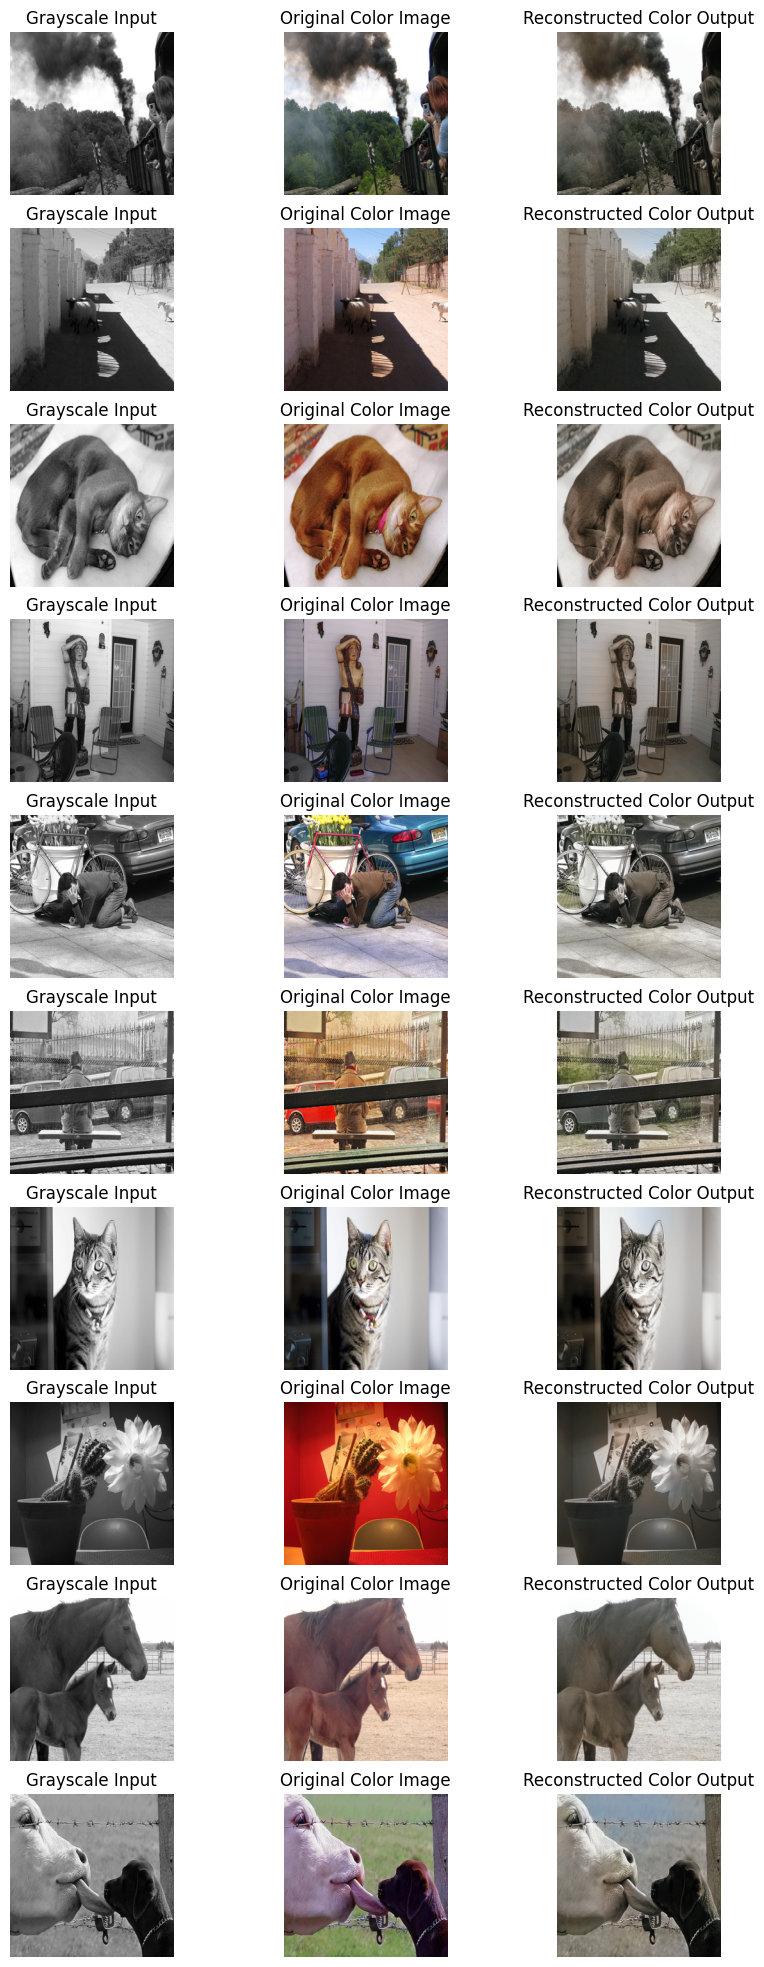

val images
Image shape before model: torch.Size([16, 1, 256, 256])


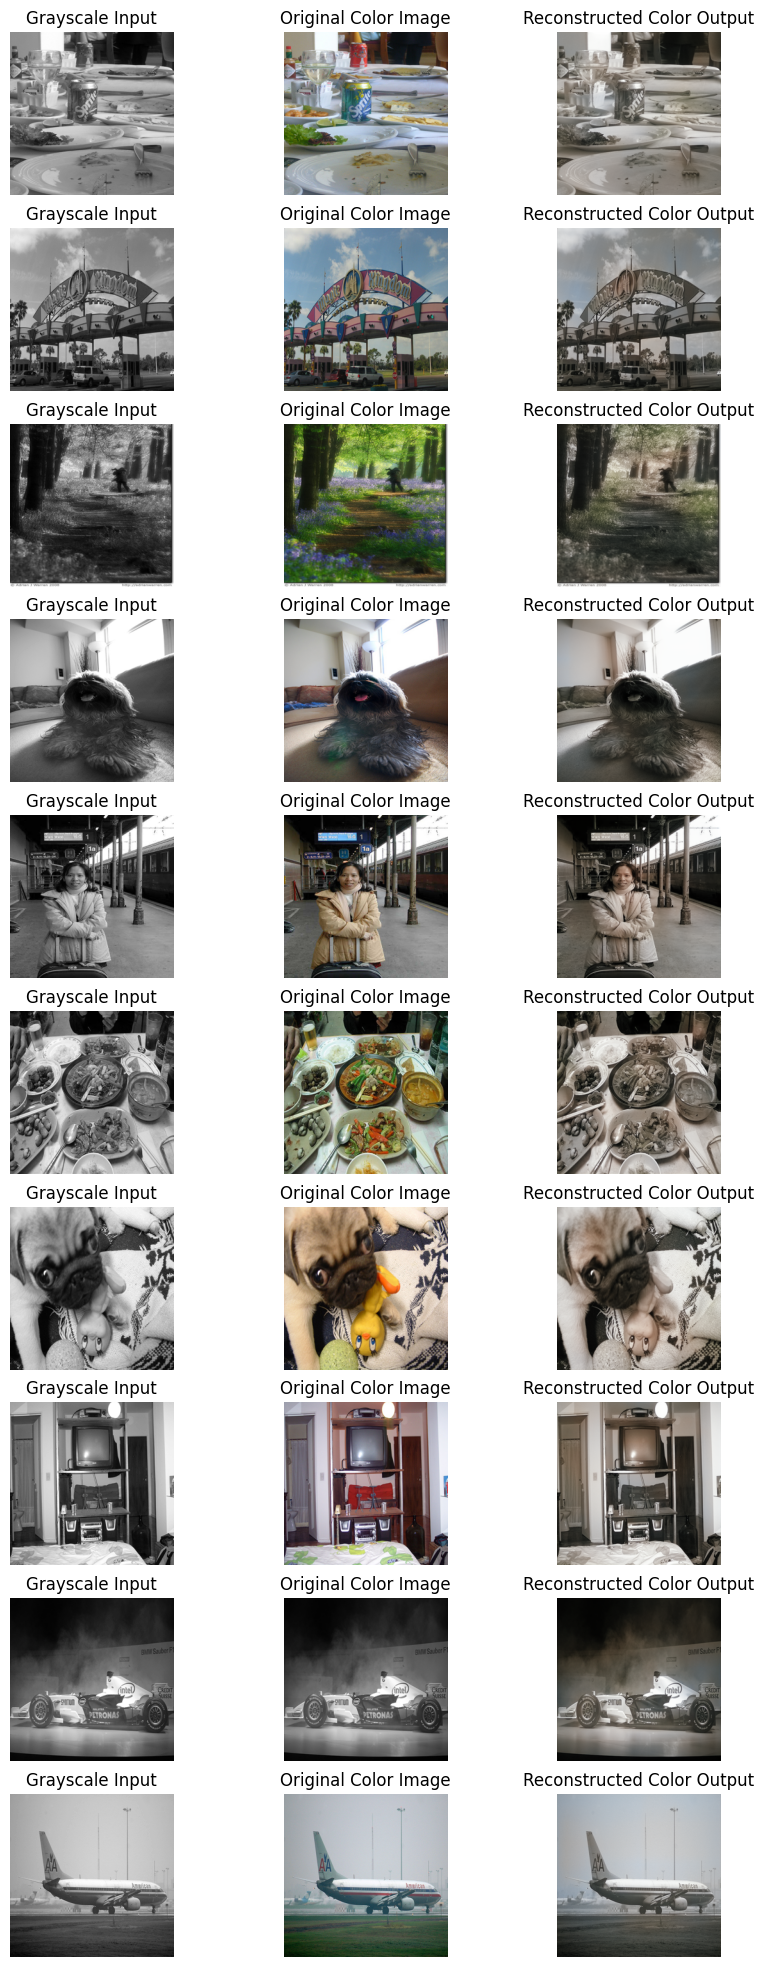

In [7]:
def visualize_results(data_loader, model, device, num_images=10):
    model.eval()
    images, color_images = next(iter(data_loader))
    images, color_images = images.to(device), color_images.to(device)
    
    # Ensure the images are properly shaped
    print("Image shape before model:", images.shape)  

    with torch.no_grad():
        outputs = model(images)
    
    images = images.cpu().squeeze(1)  
    color_images = color_images.cpu()
    outputs = outputs.cpu()
    
    fig, axs = plt.subplots(num_images, 3, figsize=(10, num_images * 2.5))
    for i in range(num_images):
        axs[i, 0].imshow(images[i].squeeze(), cmap='gray')  
        axs[i, 1].imshow(color_images[i].permute(1, 2, 0))
        axs[i, 2].imshow(outputs[i].permute(1, 2, 0))
        axs[i, 0].set_title('Grayscale Input')
        axs[i, 1].set_title('Original Color Image')
        axs[i, 2].set_title('Reconstructed Color Output')
        axs[i, 0].axis('off')
        axs[i, 1].axis('off')
        axs[i, 2].axis('off')
    plt.show()
print("trian images:")
visualize_results(train_loader, model, device)
print("val images")
visualize_results(val_loader, model, device)

In [11]:
torch.save(model, 'colorization/model2.pth')
torch.save(model.state_dict(), 'colorization/model_state_dict2.pth')